In [1]:
import pandas as pd
import numpy as np


# For saperable dataset

In [2]:
#taking idea from https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
#and taking help from Chatgpt
#read the train dataset
dataframe1 = pd.read_csv("train.txt")
dataframe1.columns=["X1",'X2',"target"]

In [3]:
#dataset
dataframe1

,X1,X2,target
0,-3.27460,2.44360,1
1,0.50871,0.64457,1
2,0.59212,-1.36930,1
3,2.14320,-2.64960,1
4,-1.40120,0.73143,1
...,...,...,...
1044,10.90600,-7.24040,3
1045,9.95010,-8.12320,3
1046,10.70900,-7.81990,3
1047,8.44400,-9.65170,3


In [4]:
#describe the dataframe with respect to the target column
f=dataframe1.groupby("target")
f.describe()

X1                                                             \
        count       mean       std     min       25%       50%       75%   
target                                                                     
1       349.0   0.113476  2.002397 -5.6623 -1.204900   0.19576   1.46230   
2       350.0  10.665218  1.849161  4.1415  9.463500  10.66950  11.97175   
3       350.0  11.247644  1.954466  6.0861  9.917075  11.23700  12.55275   

                    X2                                                     \
            max  count       mean       std      min       25%        50%   
target                                                                      
1        5.0994  349.0  -0.147837  1.487275  -4.2237 -1.255100  -0.082567   
2       15.4920  350.0  10.511364  1.850293   5.2580  9.275625  10.545500   
3       17.6000  350.0  -7.815170  1.955544 -13.2900 -9.152975  -7.846250   

                            
             75%       max  
target                      
1        0.91401   3.75000  
2       11.73925  15.36200  
3       -6.43915  -0.19891

In [5]:
#define a function to calculate the multivariate normal pdf for a every point of the meshgrid
#taking idea from https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
#and taking help from Chatgpt
def multivariate_normal_pdf(pos, mu, Sigma):
    #shape of the mu array
    n = mu.shape[0]
    #determine the determinant and inverse using numpy library
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

In [6]:
# for ploting
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def multivariate_gaussian_plot(mean_vecs, cov_mats, X1_min, X1_max, X2_min, X2_max, p_min=0, p_max=0.11,base_color='lightblue'):
    # take the point within max and min value of x and y
    X_1 = np.linspace(X1_min, X1_max, 300)
    X_2 = np.linspace(X2_min, X2_max, 300)
    X_1, X_2 = np.meshgrid(X_1, X_2)
    data = np.empty(X_1.shape + (2,))
    data[:, :, 0] = X_1
    data[:, :, 1] = X_2
    # Decrease the figure size
    fig = plt.figure(figsize=(8, 8))  
    axes = fig.add_subplot(111, projection="3d")
    #axes = fig.gca(projection="3d")
    #list for taking the z value corresponding to 3 class
    p=[0,0,0]
    i=0
    for mean_vec, cov_mat in zip(mean_vecs, cov_mats):
        l = multivariate_normal_pdf(data, mean_vec, cov_mat)
        #store the value for ofter uses
        p[i]=l
        # plot the indivisual surface
        axes.plot_surface(X=X_1, Y=X_2, Z=l, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
        #contour plot
        axes.contour(X=X_1, Y=X_2, Z=l, zdir="z", cmap=cm.viridis, offset=-0.15)
        i+=1
    #for same same draw 3 density fuction sum
    d=axes.plot_surface(X=X_1, Y=X_2, Z=p[0]+p[1]+p[2], rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
    axes.set_zlim(-0.15, p_max)
    axes.set_zticks(np.linspace(0, p_max, 5))
    #set view angle
    axes.view_init(5, -3)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Gaussian pdfs of 3 class with contour") 

    # Increase the size of the axes
    axes.auto_scale_xyz([X1_min, X1_max], [X2_min, X2_max], [0, p_max])

    plt.show()
     


In [7]:
# find the covarience matrix for different class
cov2=np.array(dataframe1[dataframe1["target"]==1].iloc[:,0:2].cov())
cov3=np.array(dataframe1[dataframe1["target"]==2].iloc[:,0:2].cov())
cov4=np.array(dataframe1[dataframe1["target"]==3].iloc[:,0:2].cov())
print(cov2)
print(cov3)
print(cov4)

[[ 4.00959221 -1.97778475]
 [-1.97778475  2.21198729]]
[[ 3.4193959  -2.30650294]
 [-2.30650294  3.42358592]]
[[3.81993808 2.86737734]
 [2.86737734 3.82415238]]


# Weighted average covarience 

In [8]:
#taking the weighted average of all class for getting a same covarience matrix
cov=(349*cov2+350*cov3+350*cov4)/1049
cov

array([[ 3.74939426, -0.47086829],
       [-0.47086829,  3.15413915]])

# Case_1

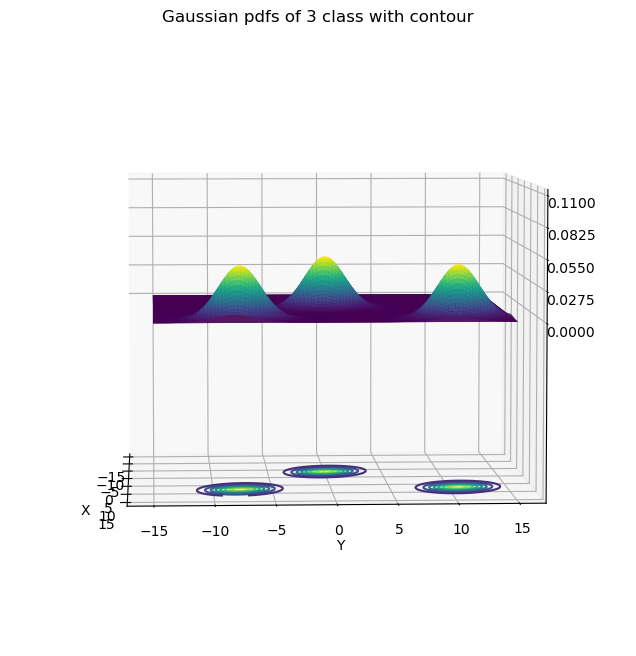

In [9]:
# give the mean and covarience and then call the funtion maultivariate_gaussian plot
mean_vecs = np.array([[0.113476,-0.147837], [10.665218,10.511364], [11.247644, -7.815170]])
cov_mats =np.array([[[3.74939426,-0.47086829],[ -0.47086829,3.15413915]], [[3.74939426,-0.47086829],[ -0.47086829,3.15413915]],[[3.74939426,-0.47086829],[ -0.47086829,3.15413915]]])

multivariate_gaussian_plot(mean_vecs, cov_mats, -15, 15, -15, 15)

# Case-2

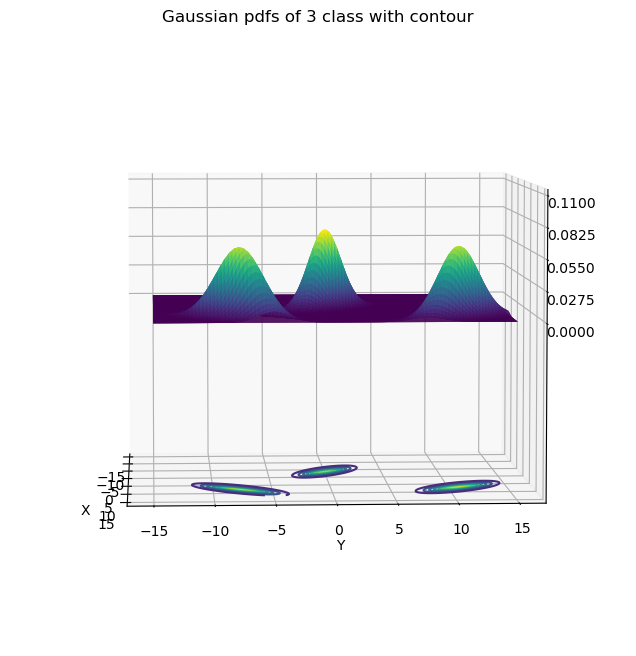

In [10]:
# give the mean and covarience and then call the funtion maultivariate_gaussian plot
mean_vecs = np.array([[0.113476,-0.147837], [10.665218,10.511364], [11.247644, -7.815170]])
cov_mats = np.array([[[ 4.00959221,-1.97778475],[-1.97778475,2.21198729]], [[3.4193959, -2.30650294], [-2.30650294,3.42358592]], [[3.81993808,2.86737734], [2.86737734,3.82415238]]])

multivariate_gaussian_plot(mean_vecs, cov_mats, -15, 15, -15, 15)

# Case-3

In [11]:
#fint the sigma for class of target 1
x=dataframe1[dataframe1["target"]==1]["X1"]
y=dataframe1[dataframe1["target"]==1]["X2"]
data = np.column_stack((x, y))
mu = np.mean(data, axis=0)
sum_squared_distances = np.sum(np.square(data - mu))
result1= sum_squared_distances / (2 * len(data))
print(result1)

3.1018763097203053


In [12]:
#fint the sigma for class of target 2
x=dataframe1[dataframe1["target"]==2]["X1"]
y=dataframe1[dataframe1["target"]==2]["X2"]
data = np.column_stack((x, y))
mu = np.mean(data, axis=0)
sum_squared_distances = np.sum(np.square(data - mu))
result2 = sum_squared_distances / (2 * len(data))
print(result2)

3.411715222318571


In [13]:
#fint the sigma for class of target 3
x=dataframe1[dataframe1["target"]==3]["X1"]
y=dataframe1[dataframe1["target"]==3]["X2"]
data = np.column_stack((x, y))
mu = np.mean(data, axis=0)
sum_squared_distances = np.sum(np.square(data - mu))
result3 = sum_squared_distances / (2 * len(data))
print(result3)

3.8111251034726727


so the weighted average is 

In [14]:
#taking the weighted average
sigma=(349*result1+350*result2+350*result3)/1049

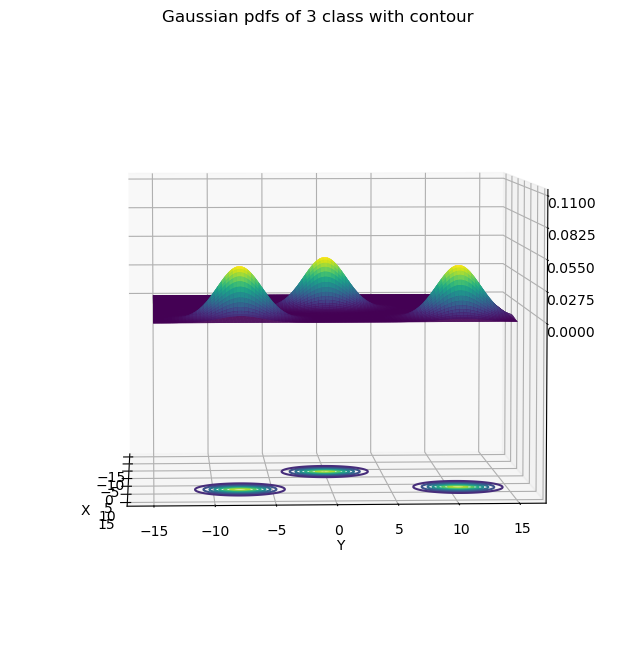

In [15]:
# features are conditionally independent so the diagonal element are 0
cov_mats = np.array([[[3.44189604015188,0],[0,3.44189604015188]], [[3.44189604015188,0],[ 0,3.44189604015188]],[[3.44189604015188,0],[ 0,3.44189604015188]]])

multivariate_gaussian_plot(mean_vecs, cov_mats, -15, 15, -15, 15)

# Case-4

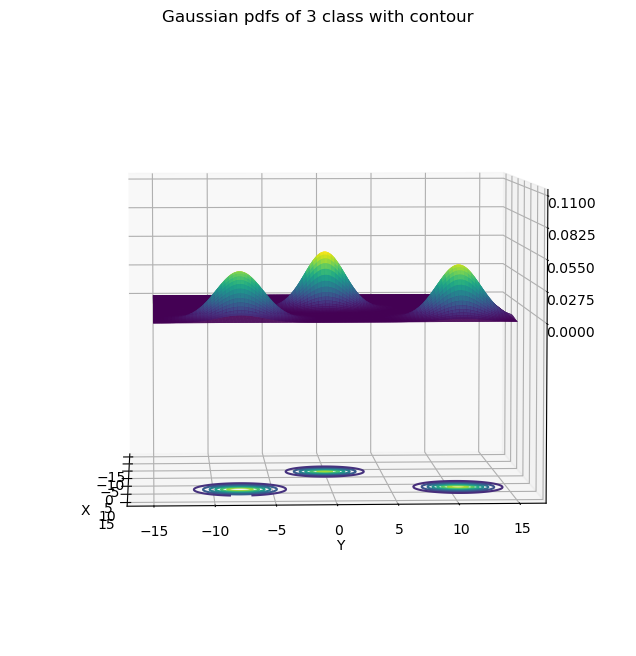

In [16]:
#Taking different sig
cov_mats = np.array([[[3.1018763097203053,0],[0,3.1018763097203053]], [[3.411715,0],[ 0,3.411715]],[[3.811125,0],[ 0,3.811125]]])

multivariate_gaussian_plot(mean_vecs, cov_mats, -15, 15, -15, 15)